In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt 
    import matplotlib.gridspec as gridspec
    
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols,i+1)

        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')

    plt.show()

In [169]:
image_orig = cv2.imread("/content/drive/MyDrive/Biến Hình Xử Lý Ảnh/Lab3/Lab03_IS_Face Detection/RonaldoMessi/Ronaldo3.jpg")
image_orig1 = cv2.imread("/content/drive/MyDrive/Biến Hình Xử Lý Ảnh/Lab3/Lab03_IS_Face Detection/RonaldoMessi/Ronaldo-Messi4.jpg")
image_orig2 = cv2.imread("/content/drive/MyDrive/Biến Hình Xử Lý Ảnh/Lab3/Lab03_IS_Face Detection/RonaldoMessi/Ronaldo-Messi1.jpg")
image_orig3 = cv2.imread("/content/drive/MyDrive/Biến Hình Xử Lý Ảnh/Lab3/Lab03_IS_Face Detection/data/test4.jpeg")


###1/  Áp dụng Haar để detect miệng từ một hình ảnh khuôn mặt (tự chọn từ internet) theo hai trường hợp : ảnh 1 khuôn mặt và ảnh nhiều khuôn mặt (>=3) (Ref : https://hackprojects.wordpress.com/tutorials/opencv-python-tutorials/opencv-mouth-detection-using-haar-cascades/ )
###2/ Viết một chức năng với input là một bức ảnh khuôn mặt theo hai trường hợp : ảnh 1 khuôn mặt và ảnh nhiều khuôn mặt (>=3)  và output là ảnh có đánh dấu mắt (đỏ), miệng (vàng) và khuôn mặt (xanh) kèm theo đó là danh sách khuôn mặt được crop ra 
###3/ Trong trường hợp detect sai khuôn mặt, viết thêm hàm để kiểm tra ảnh crop có là khuôn mặt hay không bằng 2 cách :
###Detect coi có mắt trong anh crop hay không
###Dùng skin detection để kiểm tra có phải khuôn mặt hay không


In [170]:
def is_skin_color(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
    skin_pixels = cv2.countNonZero(mask)
    total_pixels = mask.shape[0] * mask.shape[1]
    skin_ratio = skin_pixels / total_pixels
    return skin_ratio >= 0.15

def face_identify(img):
    test_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    frontalface_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    profileface_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')
    smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml') 
    lefteye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_lefteye_2splits.xml') 
    righteye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_righteye_2splits.xml') 
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml') 

    frontalface_rects = frontalface_cascade.detectMultiScale(test_image_gray, scaleFactor=1.2, minNeighbors=5)
    profileface_rects = profileface_cascade.detectMultiScale(test_image_gray, scaleFactor=1.2, minNeighbors=5)
    smile_rects = smile_cascade.detectMultiScale(test_image_gray, scaleFactor=1.2, minNeighbors=5)
    lefteye_rects = lefteye_cascade.detectMultiScale(test_image_gray, scaleFactor=1.2, minNeighbors=5)
    righteye_rects = righteye_cascade.detectMultiScale(test_image_gray, scaleFactor=1.2, minNeighbors=5)
    eye_rects = eye_cascade.detectMultiScale(test_image_gray, scaleFactor=1.2, minNeighbors=5)

    face_smile_image = test_image.copy()

    frontalface_count = len(frontalface_rects)
    profileface_count = len(profileface_rects)

    if frontalface_count >= profileface_count:
        faces_rects = frontalface_rects
    else:
        faces_rects = profileface_rects

    facelist_img = []
    smilelist_img = []
    eyelist_img = []

    for (x, y, w, h) in faces_rects:
        if (x != 0) and (y != 0):
            face_img = test_image[y:y+h, x:x+w].copy()
            face_img_detect = img[y:y+h, x:x+w].copy()
            if is_skin_color(face_img_detect):
                facelist_img.append(face_img)
                cv2.rectangle(face_smile_image, (x, y), (x+w, y+h), (0, 255, 0), 5)

                for (x_s, y_s, w_s, h_s) in smile_rects:
                    if (x <= x_s) and (y <= y_s) and (x+w >= x_s+w_s) and (y+h >= y_s+h_s):
                        smile_img = test_image[y_s:y_s+h, x_s:x_s+w].copy()
                        smilelist_img.append(smile_img)
                        cv2.rectangle(face_smile_image, (x_s, y_s), (x_s+w_s, y_s+h_s), (255, 255, 0), 5)

                for (x_l, y_l, w_l, h_l) in lefteye_rects:
                    if (x <= x_l) and (y <= y_l) and (x+w >= x_l+w_l) and (y+h >= y_l+h_l):
                        eye_left_img = test_image[y_l:y_l+h_l, x_l:x_l+w_l].copy()
                        eyelist_img.append(eye_left_img)
                        cv2.rectangle(face_smile_image, (x_l, y_l), (x_l+w_l, y_l+h_l), (255, 0, 0), 5)

                for (x_r, y_r, w_r, h_r) in righteye_rects:
                    if (x <= x_r) and (y <= y_r) and (x+w >= x_r+w_r) and (y+h >= y_r+h_r):
                        eye_right_img = test_image[y_r:y_r+h_r, x_r:x_r+w_r].copy()
                        eyelist_img.append(eye_right_img)
                        cv2.rectangle(face_smile_image, (x_r, y_r), (x_r+w_r, y_r+h_r), (0, 0, 255), 5)

                for (x_e, y_e, w_e, h_e) in eye_rects:
                    if (x <= x_e) and (y <= y_e) and (x+w >= x_e+w_e) and (y+h >= y_e+h_e):
                        eye_img = test_image[y_e:y_e+h_e, x_e:x_e+w_e].copy()
                        eyelist_img.append(eye_img)
                        cv2.rectangle(face_smile_image, (x_e, y_e), (x_e+w_e, y_e+h_e), (0, 255, 255), 5)
            else:
                print('Detected face does not have the skin color. Removing face...')

    print('Faces found:', len(facelist_img))
    print('Smiles found:', len(smilelist_img))
    print('Eyes found:', len(eyelist_img))

    ShowImage([test_image, face_smile_image], 1, 3)
    ShowImage(facelist_img, 1, len(facelist_img) + 3)
    ShowImage(smilelist_img, 1, len(smilelist_img) + 3)
    ShowImage(eyelist_img, 1, len(eyelist_img) + 3)

Faces found: 1
Smiles found: 1
Eyes found: 2


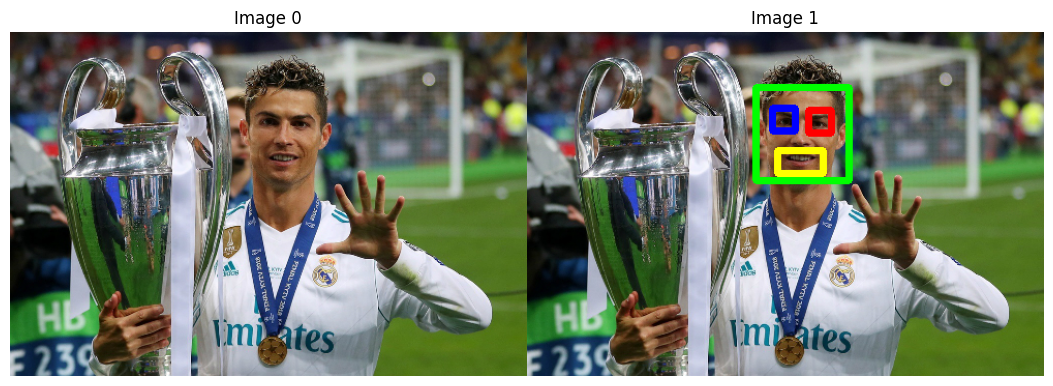

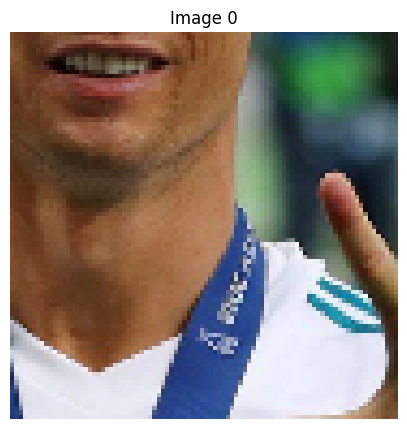

In [171]:
face_identify(image_orig)

Faces found: 3
Smiles found: 3
Eyes found: 9


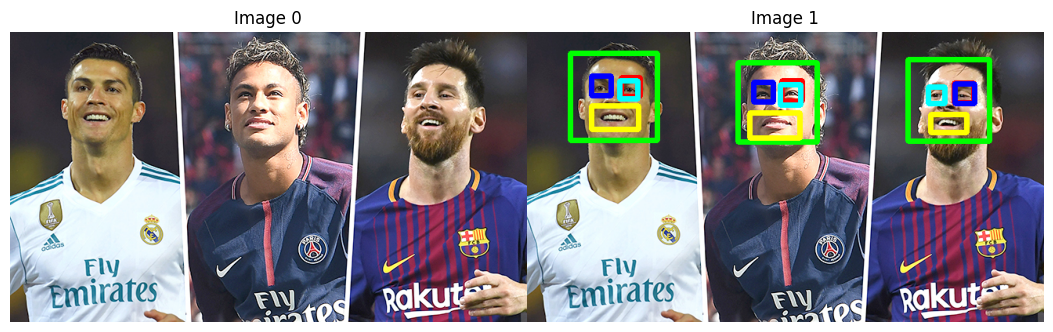

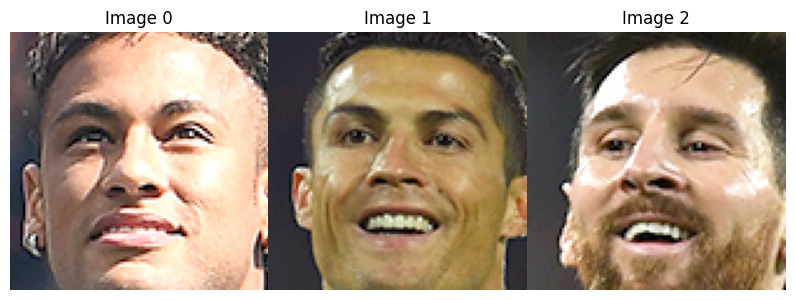

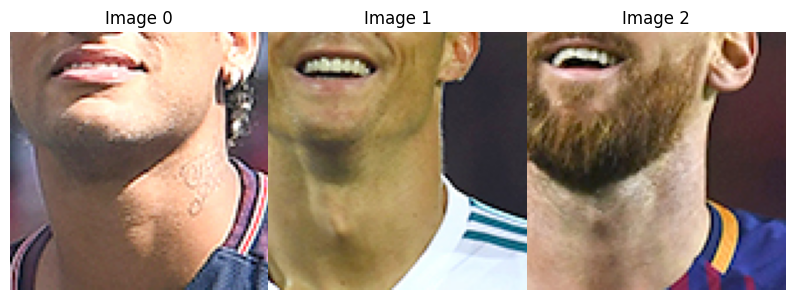

In [172]:
face_identify(image_orig1)

Faces found: 2
Smiles found: 2
Eyes found: 6


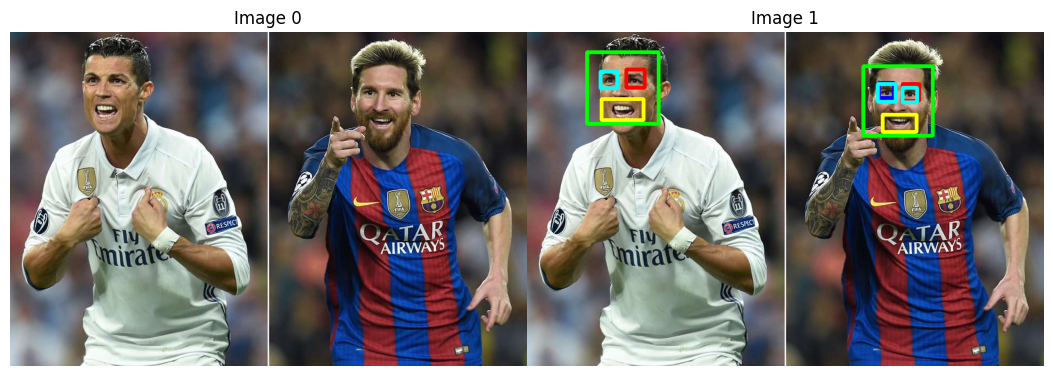

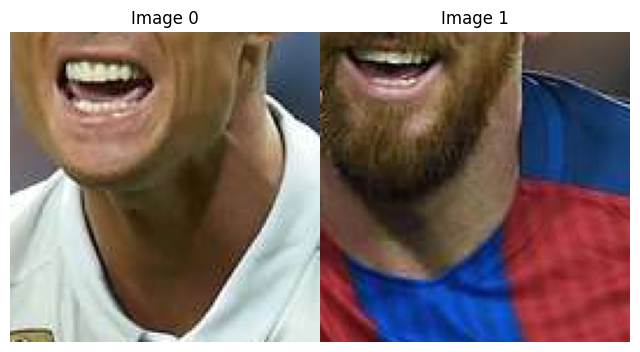

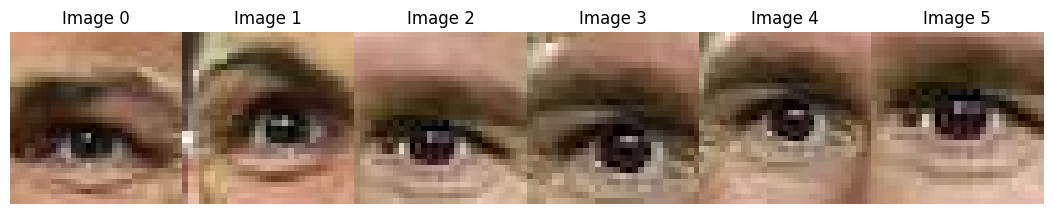

In [173]:
face_identify(image_orig2)

Detected face does not have the skin color. Removing face...
Faces found: 7
Smiles found: 10
Eyes found: 17


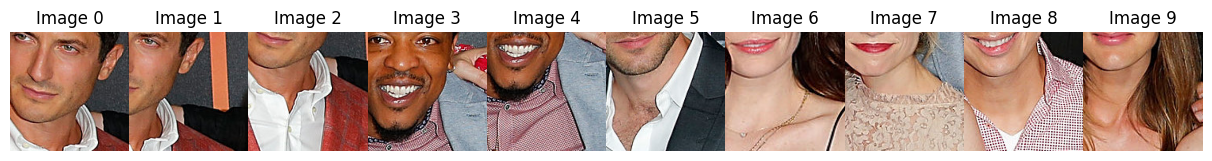

In [174]:
face_identify(image_orig3)